# **Transfer learning**

**By:** Pedro Ruiz  

---

Este Notebook busca validar la viabilidad de especializar un modelo genérico, como ResNet50 preentrenado en ImageNet, en un conjunto de categorías que le vamos a proporcionar. El objetivo es demostrar que con un ajuste fino adecuado podemos obtener un clasificador eficiente con un conjunto de datos reducido.

Realizaremos las siguientes operaciones:

1. **Importaciones**
2. **Configuraciones**
3. **Carga del modelo preentrenado**
4. **Congelación de capas**
5. **Preprocesado**
6. **Entrenamiento**
7. **Resultados**


## 1. Importaciones

In [1]:
import os
import configparser
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2. Configuración

En esta sección, estableceremos las condiciones necesarias para el entrenamiento del modelo.

Primero, fijaremos una **semilla** para asegurar la reproducibilidad de los resultados al trabajar con algoritmos estocásticos. Luego, cargaremos la **configuración** desde el archivo correspondiente y, finalmente, gestionaremos el uso del **dispositivo de cómputo** para aprovechar al máximo los recursos disponibles.


In [2]:
# Establecemos una semilla
seed = 42                                                               # Definimos la semilla,
random.seed(seed)                                                       # y la fijamos para la aleatoriedad,
np.random.seed(seed)                                                    # aplicamos para NumPy
torch.manual_seed(seed)                                                 # y para PyTorch en la CPU
if torch.cuda.is_available():                                           # Si tenemos una GPU CUDA disponible
    torch.cuda.manual_seed(seed)                                        # fijamos la semilla en GPU
    torch.backends.cudnn.deterministic = True                           # Forzamos que las convoluciones sean deterministas
    torch.backends.cudnn.benchmark = False                              # y deshabilitamos el modo benchmark para evitar variaciones

# Configuración
notebook_dir = os.getcwd()                                              # Obtenemos el directorio actual
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))        # y el directorio raíz del proyecto

config = configparser.ConfigParser()
config_path = os.path.join(project_root, 'config', 'settings.conf')     
config.read(config_path)                                                # Leemos el archivo de configuración                             

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Seleccionamos "cuda" si hay GPU, sino usamos la "cpu"

processed_data_path = os.path.join(project_root, config['data']['processed_data_path'])
transfers_path = os.path.join(project_root, config['data']['transfers_path'])
os.makedirs(transfers_path, exist_ok=True)                              # Creamos el directorio si no existe

batch_size = int(config['finetune']['batch_size'])                      # Tamaño de batch
num_epochs = int(config['finetune']['num_epochs'])                      # Número de épocas
learning_rate = float(config['finetune']['learning_rate'])              # Tasa de aprendizaje
valid_split = float(config['finetune']['valid_split'])                  # Porcentaje de validación

print(f"Usando dispositivo: {device}")
print(f"Batch size configurado: {batch_size}")
print(f"Número de épocas configurado: {num_epochs}")
print(f"Learning rate configurado: {learning_rate}")
print(f"Proporción de validación configurada: {valid_split}")

Usando dispositivo: cuda
Batch size configurado: 8
Número de épocas configurado: 20
Learning rate configurado: 0.0005
Proporción de validación configurada: 0.2


A continuación, crearemos una **clase** para gestionar el *dataset* organizado por **clases en directorios**.

- **Detecta** las carpetas de conjunto como *clases* y les asigna **índices numéricos**.
- **Busca** imágenes `.jpg` dentro de las subcarpetas, asociándolas a la *clase correspondiente*.
- **Aplica** el *preprocesamiento* a las imágenes antes de retornarlas.

In [ ]:
class ProcessedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):                           # El constructor recibe la ruta de datos y una posible transformación,
        self.root = root                                                # almacenamos la ruta raíz, la transformación (si la hay) y las listas de imágenes y etiquetas
        self.transform = transform
        self.images = []
        self.labels = []

        # Identificación de clases
        self.classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]         # Creamos una lista con las clases encontradas en el directorio raíz
        self.classes.sort()                                                                         # ordenamos alfabéticamente
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}                # y creamos un diccionario de mapeo de clases a índices

        # Bucle de alimentación
        for cls in self.classes:
            cls_path = os.path.join(root, cls)                                                      # Ruta de la clase actual
            for video_dir in os.listdir(cls_path):                                                  # Iteramos sobre cada directorio dentro de la clase
                video_path = os.path.join(cls_path, video_dir)                                      # Ruta del vídeo
                if os.path.isdir(video_path):                                                       # Si es un directorio (un vídeo),
                    for frame_name in os.listdir(video_path):                                       # iteramos sobre cada frame
                        if frame_name.endswith('.jpg'):                                             # contemplando sólo los archivos .jpg
                            frame_path = os.path.join(video_path, frame_name)                       # Ruta del fotograma
                            self.images.append(frame_path)                                          # Añadimos la ruta del frame a la lista
                            self.labels.append(self.class_to_idx[cls])                              # y la etiqueta de la clase a la que corresponde.

    def __len__(self):                                                  # Número total de imágenes en el dataset
        return len(self.images)                                         

    def __getitem__(self, idx):                                         # Obtener un elemento (imagen, etiqueta) dado un índice
        img_path = self.images[idx]                                     # Extraemos la ruta de la imagen correspondiente al índice,
        label = self.labels[idx]                                        # la etiqueta correspondiente.
        img = Image.open(img_path).convert("RGB")                       # Abrimos la imagen y la transformamos a RGB
        if self.transform:                                              # Si definimos más transformaciones las aplicamos
            img = self.transform(img)
        return img, label

## 3. Preprocesado  

En este apartado, llevaremos a cabo el *preprocesamiento* de las imágenes del *dataset*. Para lograrlo, definiremos una serie de transformaciones que se aplicarán a cada imagen antes de que se utilicen en el entrenamiento del modelo. Estas transformaciones incluyen:  

- **El ajuste del tamaño de las imágenes** a *224x224 píxeles*.  
- **La conversión a tensores**.  
- **La normalización de los píxeles** según los parámetros de *ImageNet*.  

Posteriormente, inicializaremos el *dataset* con la clase `ProcessedDataset` y aplicaremos las transformaciones especificadas. Además, aprovecharemos para:  
- Extraer las clases presentes.  
- Calcular el número total de clases y de imágenes.  

Esto nos dará una **visión general** del conjunto de datos. 

In [41]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),                                                          # Ajustamos el tamaño de la imagen a 224x224,
    transforms.ToTensor(),                                                                  # transformamos las imágenes a tensores
    transforms.Normalize(                                                                   # y normalizamos con parámetros de ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Dataset con las transformaciones
dataset = ProcessedDataset(root=processed_data_path)                                        # Inicializamos el dataset,
class_names = dataset.classes                                                               # extraemos las clases y calculamos su número
num_classes = len(class_names)
print("Clases:", class_names, f"-- Nº Clases: {num_classes}")
print(f"Nº total de frames almacenados en processed/: {len(dataset)}")

Clases: ['cooking', 'traffic', 'videoclip'] -- Nº Clases: 3
Nº total de frames almacenados en processed/: 419456


In [42]:
# Subset
max_samples = len(dataset) // 4                                                             # Calculamos el máximo de muestras con un cuarto del dataset
print(f"{max_samples} muestras. Representación de un cuarto del conjunto")

# Reducción del dataset
if len(dataset) > max_samples:                                                              # Si el dataset tiene más muestras las indicadas:
    indices = list(range(len(dataset)))                                                     # Creamos una lista de índices,
    random.shuffle(indices)                                                                 # los barajamos aleatoriamente,
    sampled_indices = indices[:max_samples]                                                 # Seleccionamos  los primeros hasta llegar al maximo permitido
    dataset = Subset(dataset, sampled_indices)                                              # y creamos un subset.
    print(f"Dataset resultante: {len(dataset)}")

# Split Train/Val
val_size = int(len(dataset) * valid_split)                                                  # Calculamos el tamaño de validación y de entrenamiento
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])                  # y dividimos el dataset.
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)               # Creamos el DataLoaders para el entrenamiento y lo barajamos
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


104864 muestras. Representación de un cuarto del conjunto
Dataset resultante: 104864
Train samples: 83892, Val samples: 20972


## 4. Entrenamiento  

A continuación, llevaremos a cabo el **ajuste fino** del modelo y su entrenamiento para adaptarlo a nuestro conjunto. El proceso incluirá los siguientes pasos:  

1. **Se cargará el modelo *ResNet50* preentrenado en *ImageNet***.  
2. **Congelaremos las capas del modelo** para preservar las características aprendidas en *ImageNet*.  
3. **Adaptaremos la capa final** del modelo para que coincida con el número de clases de nuestro conjunto de datos.  
4. Utilizaremos la **entropía cruzada** como función de pérdida y el optimizador **Adam** para ajustar los pesos de la capa final.  
5. **Entrenaremos el modelo** utilizando el conjunto de datos de entrenamiento y validación, aplicando técnicas de *early stopping* para evitar el sobreajuste.  

In [38]:
# Modelo preentrenado
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Congelar capas
for param in model.parameters():                                                    # Iteramos los parámetros del modelo
    param.requires_grad = False                                                     # y los congelamos para que no se actualicen durante el entrenamiento

# Reemplazar capa final
in_features = model.fc.in_features                                                  # Extraemos el número de características de entrada de la capa final,
model.fc = nn.Linear(in_features, num_classes)                                      # reemplazamos la capa final para que coincida con las clases de nuestro conjunto
model = model.to(device)                                                            # y movemos el modelo al dispositivo.

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()                                                   # Definimos la función de pérdida como entropía cruzada
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)                     # Usamos el optimizador Adam para ajustar los pesos de la capa final

best_val_loss = float('inf')                                                        # Inicializamos la mejor pérdida de validación como infinito
train_losses = []                                                                   # e inicializamos las listas para almacenar las pérdidas de entrenamiento
val_losses = []

# Early Stopping
patience = 5                                                                        # Definimos la paciencia para early stopping
counter = 0                                                                         # Contador para el número de épocas sin mejora

for epoch in range(num_epochs):                                                     # Iteramos sobre el número de épocas
    model.train()                                                                   # Ponemos el modelo en modo de entrenamiento
    running_loss = 0.0                                                              # e inicializamos la pérdida acumulada y el total de muestras
    total_train = 0

    # Bucle de entrenamiento
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):        # Iteramos sobre el DataLoader de entrenamiento
        images, labels = images.to(device), labels.to(device)                       # Movemos las imágenes y etiquetas al dispositivo,
        optimizer.zero_grad()                                                       # reiniciamos los gradientes del optimizador,
        outputs = model(images)                                                     # obtenemos las predicciones,
        loss = criterion(outputs, labels)                                           # calculamos la pérdida,
        loss.backward()                                                             # calculamos los gradientes,
        optimizer.step()                                                            # actualizamos los pesos,
        running_loss += loss.item() * images.size(0)                                # acumulamos la pérdida y el total de muestras
        total_train += images.size(0)

    epoch_loss = running_loss / total_train                                         # Calculamos la pérdida promedio de la época
    train_losses.append(epoch_loss)                                                 # y añadimos la pérdida de entrenamiento a la lista

    # Validación
    model.eval()                                                                    # Ponemos el modelo en modo de evaluación
    val_running_loss = 0.0                                                          # Inicializamos la pérdida acumulada de validación
    val_total = 0                                                                   # Inicializamos el total de muestras de validación
    with torch.no_grad():                                                           # Desactivamos el cálculo de gradientes
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):        # Iteramos sobre el DataLoader de validación
            images, labels = images.to(device), labels.to(device)                   # Movemos las imágenes y etiquetas al dispositivo
            outputs = model(images)                                                 # Obtenemos las predicciones del modelo
            loss = criterion(outputs, labels)                                       # Calculamos la pérdida
            val_running_loss += loss.item() * images.size(0)                        # Acumulamos la pérdida
            val_total += images.size(0)                                             # Acumulamos el total de muestras

    val_loss = val_running_loss / val_total                                         # Calculamos la pérdida promedio de la validación
    val_losses.append(val_loss)                                                     # Añadimos la pérdida de validación a la lista

    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Val Loss={val_loss:.4f}") # Imprimimos las pérdidas de la época

    # Early Stopping
    if val_loss < best_val_loss:                                                    # Si la pérdida de validación es mejor que la mejor pérdida registrada
        best_val_loss = val_loss                                                    # Actualizamos la mejor pérdida de validación
        counter = 0                                                                 # Reiniciamos el contador de épocas sin mejora
        best_model_path = os.path.join(transfers_path, 'resnet_finetuned.pth')      # Definimos la ruta para guardar el mejor modelo
        torch.save({                                                                # Guardamos el estado del modelo y las clases
            'model_state_dict': model.state_dict(),
            'class_names': class_names
        }, best_model_path)
        print(f"Modelo guardado en {best_model_path}")                              # Imprimimos que el modelo ha sido guardado
    else:                                                                           # Si no hay mejora en la pérdida de validación
        counter += 1                                                                # Incrementamos el contador de épocas sin mejora
        print(f"Sin mejora en validación durante {counter} épocas seguidas.")       # Imprimimos el número de épocas sin mejora
        if counter >= patience:                                                     # Si el contador alcanza la paciencia definida
            print(f"Deteniendo el entrenamiento en la época {epoch+1} por early stopping.")         # Imprimimos que se detiene el entrenamiento por early stopping
            break 

Validation Epoch 1/20: 100%|██████████| 2622/2622 [01:41<00:00, 25.81it/s]


Epoch 1: Train Loss=0.0753, Val Loss=0.0377
Modelo guardado en ../data/models/transfers\resnet_finetuned.pth


Validation Epoch 2/20: 100%|██████████| 2622/2622 [01:16<00:00, 34.22it/s]


Epoch 2: Train Loss=0.0465, Val Loss=0.0371
Modelo guardado en ../data/models/transfers\resnet_finetuned.pth


Validation Epoch 3/20: 100%|██████████| 2622/2622 [01:23<00:00, 31.52it/s]


Epoch 3: Train Loss=0.0418, Val Loss=0.0400
Sin mejora en validación durante 1 épocas seguidas.


Validation Epoch 4/20: 100%|██████████| 2622/2622 [01:15<00:00, 34.50it/s]


Epoch 4: Train Loss=0.0375, Val Loss=0.0359
Modelo guardado en ../data/models/transfers\resnet_finetuned.pth


Validation Epoch 5/20: 100%|██████████| 2622/2622 [01:16<00:00, 34.41it/s]


Epoch 5: Train Loss=0.0371, Val Loss=0.0313
Modelo guardado en ../data/models/transfers\resnet_finetuned.pth


Validation Epoch 6/20: 100%|██████████| 2622/2622 [01:15<00:00, 34.55it/s]


Epoch 6: Train Loss=0.0357, Val Loss=0.0305
Modelo guardado en ../data/models/transfers\resnet_finetuned.pth


Validation Epoch 7/20: 100%|██████████| 2622/2622 [01:14<00:00, 35.12it/s]


Epoch 7: Train Loss=0.0350, Val Loss=0.0337
Sin mejora en validación durante 1 épocas seguidas.


Validation Epoch 8/20: 100%|██████████| 2622/2622 [01:14<00:00, 35.16it/s]


Epoch 8: Train Loss=0.0335, Val Loss=0.0353
Sin mejora en validación durante 2 épocas seguidas.


Validation Epoch 9/20: 100%|██████████| 2622/2622 [01:13<00:00, 35.52it/s]


Epoch 9: Train Loss=0.0337, Val Loss=0.0348
Sin mejora en validación durante 3 épocas seguidas.


Validation Epoch 10/20: 100%|██████████| 2622/2622 [01:16<00:00, 34.11it/s]


Epoch 10: Train Loss=0.0329, Val Loss=0.0343
Sin mejora en validación durante 4 épocas seguidas.


Validation Epoch 11/20: 100%|██████████| 2622/2622 [01:17<00:00, 33.74it/s]

Epoch 11: Train Loss=0.0335, Val Loss=0.0340
Sin mejora en validación durante 5 épocas seguidas.
Deteniendo el entrenamiento en la época 11 por early stopping.


## 5. Resultados

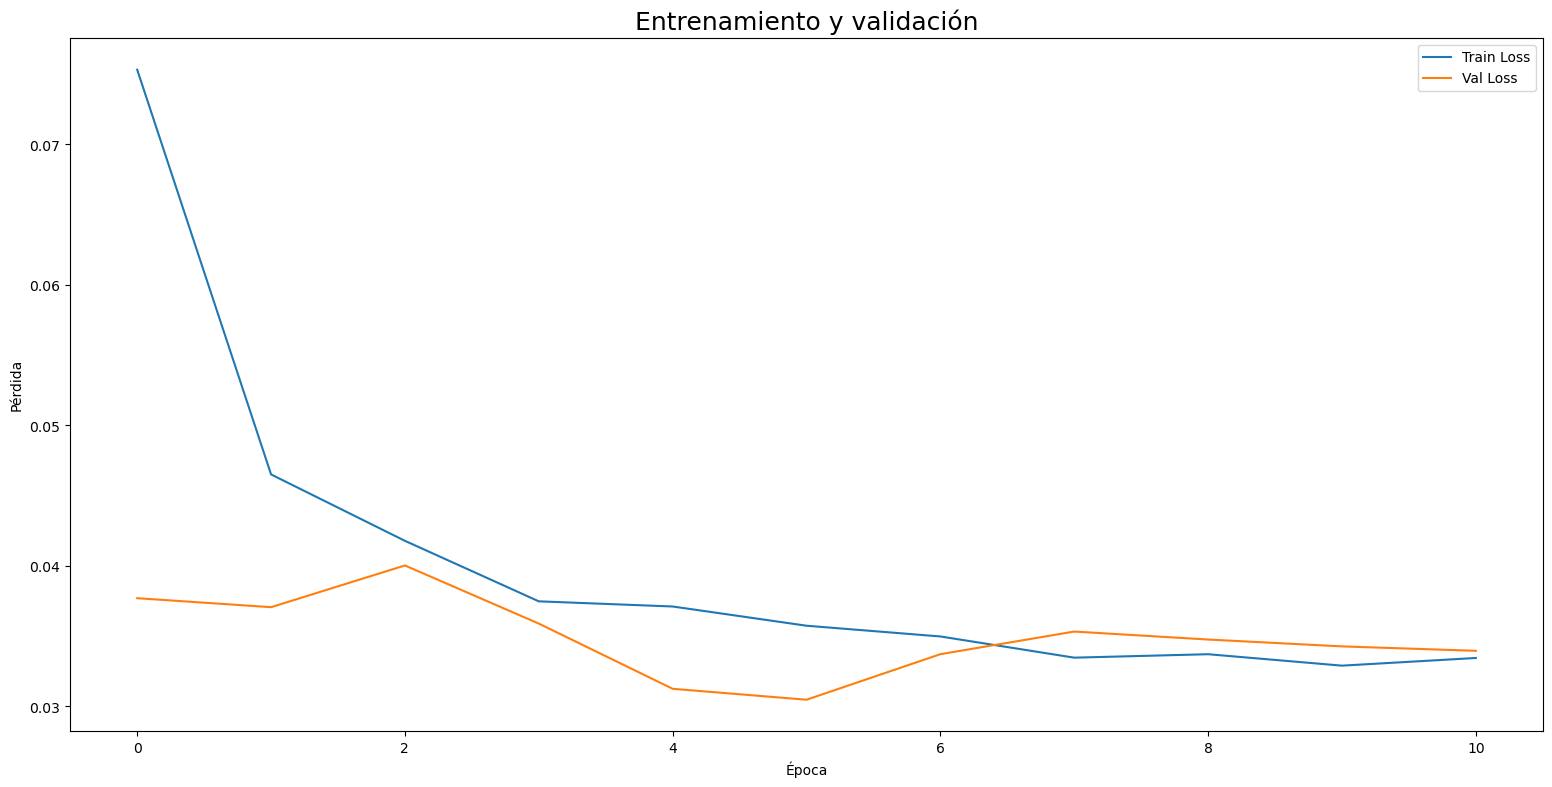

In [39]:
plt.figure(figsize=(19,9))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Entrenamiento y validación', fontsize=18)

plt.legend()
plt.show()

In [44]:
average_train_loss = sum(train_losses) / len(train_losses)
average_val_loss = sum(val_losses) / len(val_losses)
best_epoch = val_losses.index(min(val_losses)) + 1
best_val_loss = min(val_losses)

print(f"Pérdida promedio del entrenamiento: {average_train_loss:.4f}")
print(f"Pérdida promedio de la validación: {average_val_loss:.4f}")
print(f"Mejor época: {best_epoch}. con una pérdida de validación: {best_val_loss:.4f}")

Pérdida promedio del entrenamiento: 0.0402
Pérdida promedio de la validación: 0.0350
Mejor época: 6. con una pérdida de validación: 0.0305


La gráfica muestra una **reducción constante** durante las primeras seis épocas, **indicando un aprendizaje bastante bueno**. A partir de la sexta época, la pérdida en validación **comienza a aumentar y luego se estabiliza**. Tras algunas épocas adicionales sin mejoras, el proceso de *early stopping* detiene el entrenamiento. Esto **revela signos de *overfitting***, donde el modelo comienza a **memorizar los datos de entrenamiento** en lugar de generalizar.

Según los resultados obtenidos, **la mejor época fue la sexta**, con pérdidas promedio **muy similares** entre el entrenamiento y la validación. Parece que **la regularización y los hiperparámetros están bien ajustados**. Además, el desempeño del modelo en validación es **razonable**, con una **diferencia muy pequeña** respecto al entrenamiento.